In [1]:
import math as m
import numpy as np
import random as r
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from torch import optim

In [3]:
from nflows.flows.base import Flow
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms.splines.rational_quadratic import rational_quadratic_spline
from nflows.transforms.dequantization import UniformDequantization
from nflows.transforms.dequantization import VariationalDequantization

In [4]:
#device = torch.device("cuda:0")
device = torch.device("cpu")

In [5]:
def generate(n, d, r):
    # Continuous dimension is sampled from e^rx
    selected_dims_mask = np.random.rand(n,1) < np.arange(1,d+1)/d
    x_discrete = np.argmax(selected_dims_mask * np.arange(d,0,-1), axis = 1)

    x_continuous = np.log(np.ones(n) + np.random.rand(n)*(m.exp(r) - 1))/r
    # Flip all distributions with odd label
    x_continuous[x_discrete%2==1] = 1 - x_continuous[x_discrete%2==1]

    x_out = np.zeros((n,2))
    x_out[:,0] = x_continuous
    x_out[:,1] = x_discrete
    return x_out


In [6]:
n_data = int(1e6)
d_discrete = 2
x_data = torch.tensor(generate(n_data, d_discrete, 2), dtype=torch.float32, device=device)

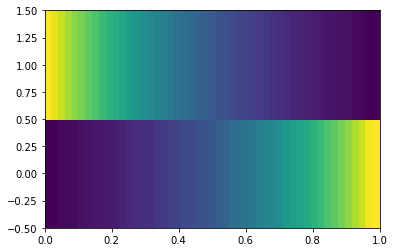

In [7]:
bins_x = np.linspace(0, 1, 50)
bins_y = np.linspace(-0.5, d_discrete-0.5, d_discrete+1)
plt.hist2d(x_data[:,0].numpy(), x_data[:,1].numpy(), bins=[bins_x, bins_y])
plt.show()

In [8]:
num_layers = 6
base_dist_uniform = BoxUniform(torch.zeros(2), torch.ones(2))
base_dist_variational = BoxUniform(torch.zeros(2), torch.ones(2))

transforms_uniform = []
transforms_variational = []

transforms_uniform.append(UniformDequantization(max_labels=torch.tensor([-1,d_discrete-1])))
transforms_variational.append(VariationalDequantization(max_labels=torch.tensor([-1,d_discrete-1]), rqs_hidden_features=15, rqs_flow_layers=2))

for _ in range(num_layers):
    transforms_uniform.append(RandomPermutation(features=2))
    transforms_uniform.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=2, 
        hidden_features=10,
        num_bins=5,
        num_blocks=4,
    ))

    transforms_variational.append(RandomPermutation(features=2))
    transforms_variational.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=2, 
        hidden_features=10,
        num_bins=5,
        num_blocks=4,
    ))

transform_uniform = CompositeTransform(transforms_uniform)
transform_variational = CompositeTransform(transforms_variational)

flow_uniform = Flow(transform_uniform, base_dist_uniform).to(device)
flow_variational = Flow(transform_variational, base_dist_variational).to(device)

optimizer_uniform = optim.Adam(flow_uniform.parameters())
optimizer_variational = optim.Adam(flow_variational.parameters())

In [9]:
n_epochs = 200
batch_size = 1000
n_batches = m.ceil(x_data.shape[0]/batch_size)

for epoch in range(n_epochs):
    permutation = torch.randperm(x_data.shape[0], device=device)    

    # Loop over batches
    cum_loss_uniform = 0
    cum_loss_variational = 0
    for batch in range(n_batches):
        # Set up the batch
        batch_begin = batch*batch_size
        batch_end   = min( (batch+1)*batch_size, x_data.shape[0]-1 )
        indices = permutation[batch_begin:batch_end]
        batch_x = x_data[indices]
        
        # Take a step
        optimizer_uniform.zero_grad()
        optimizer_variational.zero_grad()

        loss_uniform = -flow_uniform.log_prob(inputs=batch_x).mean()
        loss_variational = -flow_variational.log_prob(inputs=batch_x).mean()

        loss_uniform.backward()
        loss_variational.backward()

        optimizer_uniform.step()
        optimizer_variational.step()

        # Compute cumulative loss
        cum_loss_uniform = (cum_loss_uniform*batch + loss_uniform.item())/(batch+1)
        cum_loss_variational = (cum_loss_variational*batch + loss_variational.item())/(batch+1)

        print("epoch = ", epoch, "batch = ",batch+1, "/", n_batches, "loss_uniform = ", cum_loss_uniform, " loss_variational = ", cum_loss_variational)

09
epoch =  0 batch =  530 / 1000 loss_uniform =  -0.051655771630104486  loss_variational =  -0.06687728324268051
epoch =  0 batch =  531 / 1000 loss_uniform =  -0.05183040029820924  loss_variational =  -0.06701194098120182
epoch =  0 batch =  532 / 1000 loss_uniform =  -0.05194418566915052  loss_variational =  -0.06709201992695096
epoch =  0 batch =  533 / 1000 loss_uniform =  -0.05214672182458601  loss_variational =  -0.06726799774141792
epoch =  0 batch =  534 / 1000 loss_uniform =  -0.05230055830798073  loss_variational =  -0.06740434264327308
epoch =  0 batch =  535 / 1000 loss_uniform =  -0.05244880915145067  loss_variational =  -0.0675235396536137
epoch =  0 batch =  536 / 1000 loss_uniform =  -0.0525813792085487  loss_variational =  -0.06762801755959025
epoch =  0 batch =  537 / 1000 loss_uniform =  -0.05276361822815753  loss_variational =  -0.06777762298604903
epoch =  0 batch =  538 / 1000 loss_uniform =  -0.05292397243560198  loss_variational =  -0.06790962051076568
epoch = 

KeyboardInterrupt: 

In [33]:
n_sample = 1000000
with torch.no_grad():
    x_uniform = flow_uniform.sample(n_sample).cpu().numpy()
    x_variational = flow_variational.sample(n_sample).cpu().numpy()

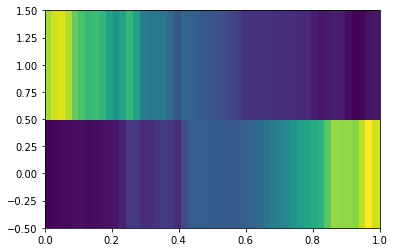

In [34]:
# x_uniform
plt.hist2d(x_uniform[:,0], x_uniform[:,1], bins=[bins_x, bins_y])
plt.show()

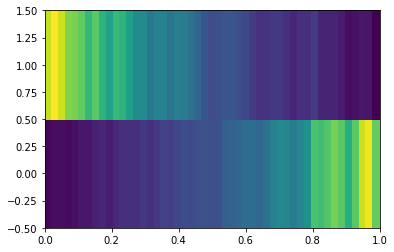

In [35]:
# x_variational
plt.hist2d(x_variational[:,0], x_variational[:,1], bins=[bins_x, bins_y])
plt.show()

In [36]:
with torch.no_grad():
    x_uniform_dequantized = flow_uniform._transform._transforms[0].forward(x_data)[0].cpu().numpy()
    x_variational_dequantized = flow_variational._transform._transforms[0].forward(x_data)[0].cpu().numpy()

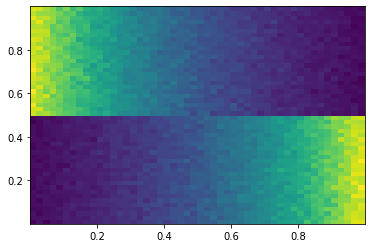

In [37]:
# x_uniform
plt.hist2d(x_uniform_dequantized[:,0], x_uniform_dequantized[:,1], bins=50)
plt.show()

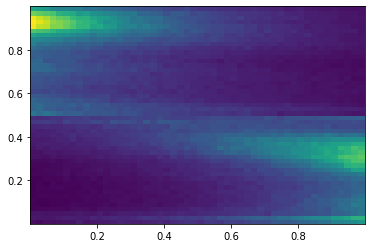

In [38]:
# x_variational
plt.hist2d(x_variational_dequantized[:,0], x_variational_dequantized[:,1], bins=50)
plt.show()

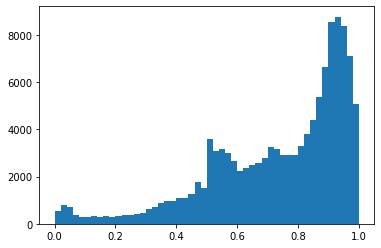

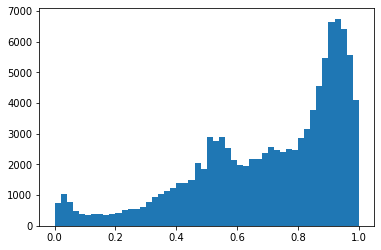

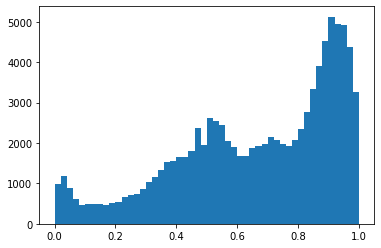

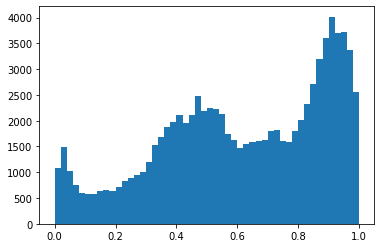

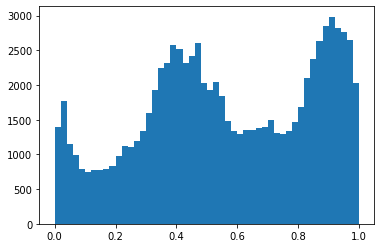

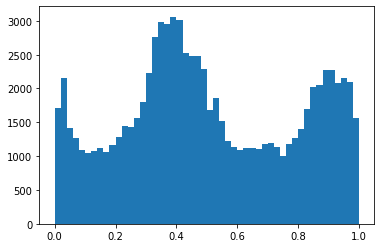

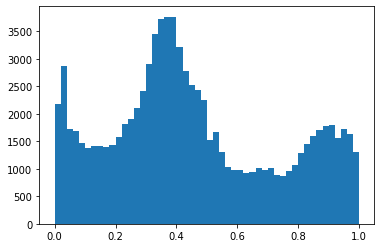

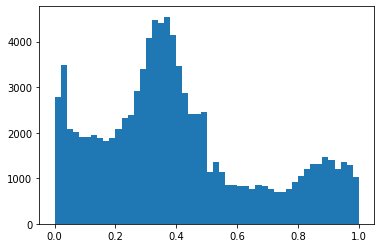

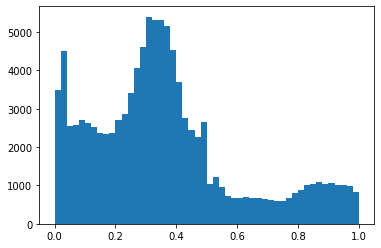

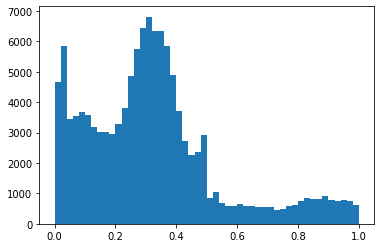

In [39]:
for i in range(10):
    mask = np.logical_and(x_variational_dequantized[:,0] > i/10, x_variational_dequantized[:,0] < (i+1)/10)
    plt.hist(x_variational_dequantized[mask][:,1], bins=50)
    plt.show()

In [40]:
x_variational_dequantized[:,0] > 0.7

array([False, False, False, ...,  True, False, False])

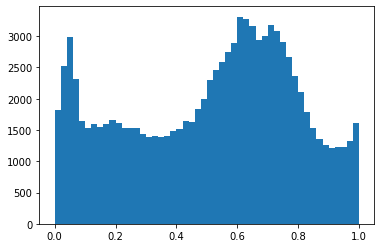

In [41]:
context = torch.tensor([[0.9, 0]]) 
with torch.no_grad():
    x_deq = flow_variational._transform._transforms[0]._flow.sample(100000, context=context).cpu().squeeze()
plt.hist(x_deq, bins = 50)
plt.show()

In [60]:
x_deq.shape

(1, 10000, 1)

In [73]:
np.max(x_uniform_dequantized[:,1])

0.6666657